In [13]:
import numpy as np 
import pandas as pd 
import os, re
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from functools import partial
from tensorflow.keras.applications import EfficientNetB3
import efficientnet.tfkeras as efn


AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 300
N_CLASSES = 101
# Create a generator
GEN = tf.random.Generator.from_seed(42, alg='philox')

## Loading and Visualizing

In [14]:
# load the data with shuffling
dataset, info = tfds.load('food101', as_supervised=True, shuffle_files=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.vision.ee.ethz.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteLNVFB8/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteLNVFB8/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [15]:
info.splits

{'train': <tfds.core.SplitInfo num_examples=75750>,
 'validation': <tfds.core.SplitInfo num_examples=25250>}

In [16]:
# get data labels
class_names = info.features["label"].names
n_classes = len(class_names)
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [17]:
# split data using S3 split API
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "food101",
    split=["validation", "train[:15%]", "train[15%:]"],
    as_supervised=True)

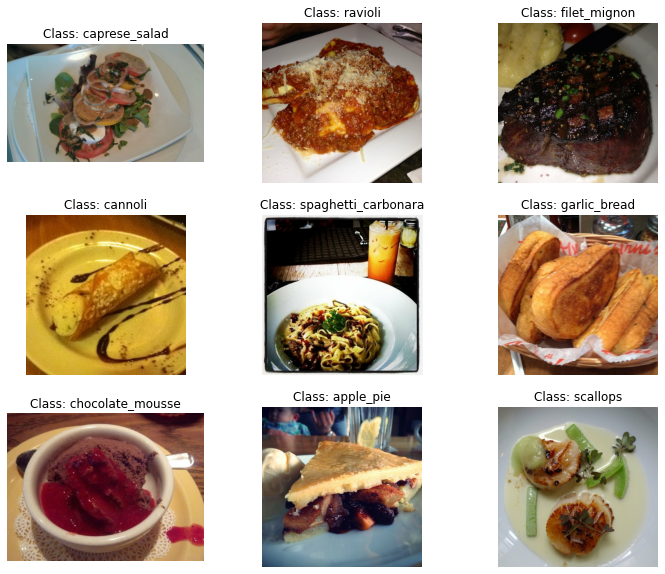

In [18]:
# visualize some data
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

## Preprocessing

There are several ways to preprocess data: 
- apply preprocessing (custom function or keras preprocessing layer) to the dataset by calling map;
- include preprocessing directly inside model definition (simplify deployment).

In [19]:

# A wrapper function for updating seeds
def f(x):
    seed = GEN.make_seeds(2)[0]
    image = augment(x, seed)
    return image

# augmentation
def augment(image, seed, batch_size=BATCH_SIZE):
    # Make a new seed
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
        
    # Random crop
    image = tf.image.stateless_random_crop(
        image, size=[batch_size, IMG_SIZE, IMG_SIZE, 3], seed=seed)
    
    # Random flip
    image = tf.image.stateless_random_flip_left_right(image, new_seed)
    
    # Random brightness
    image = tf.image.stateless_random_brightness(
        image, max_delta=0.5, seed=new_seed)
    return image

# model specific preprocessing
def preprocess(image):
    resized_image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return keras.applications.efficientnet.preprocess_input(resized_image)

### Input pipelines

In [20]:
# configure datasets for performance
def prepare(ds, batch_size=BATCH_SIZE, shuffle=False, augmentation=False):
    # standardize shape of images
    ds = ds.map(lambda x, y: (tf.image.resize_with_crop_or_pad(x, IMG_SIZE*2, IMG_SIZE*2), y),
               num_parallel_calls=AUTOTUNE)
    
    # shuffle training dataset
    if shuffle:
        ds = ds.shuffle(1024)
    
    # vectorize transformations
    ds = ds.batch(batch_size, drop_remainder=True)
    
    # augment training dataset
    if augmentation:
        ds = ds.map(lambda x, y: (f(x), y),
                    num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (tf.image.central_crop(x, central_fraction=0.8), y),
                   num_parallel_calls=AUTOTUNE)
        
    # final model dependent preprocessing
    ds = ds.map(lambda x, y: (preprocess(x), y),
               num_parallel_calls=AUTOTUNE)

    # overlap producer and consumer works
    return ds.prefetch(AUTOTUNE)

train_set = prepare(train_set_raw, shuffle=True, augmentation=True)
valid_set = prepare(valid_set_raw)
test_set = prepare(test_set_raw)

### Model training

In [21]:
# plot some training statistics
def plot_hist(hist):
    plt.plot(hist.history["sparse_categorical_accuracy"])
    plt.plot(hist.history["val_sparse_categorical_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [22]:
NUM_TRAINING_IMAGES = round(info.splits['train'].num_examples * 0.85)
NUM_VALIDATION_IMAGES = info.splits['validation'].num_examples
NUM_TEST_IMAGES = round(info.splits['train'].num_examples * 0.15)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALIDATION_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE
TEST_STEPS = NUM_TEST_IMAGES // BATCH_SIZE

In [12]:
# define model architecture
base_model = EfficientNetB3(include_top=False, pooling='avg', input_shape=(None, None, 3),
                            weights='../input/efficientnet-keras-noisystudent-weights-b0b7/noisystudent/noisy.student.notop-b3.h5')
dropout = keras.layers.Dropout(.5)(base_model.output)
output = keras.layers.Dense(N_CLASSES, activation="softmax")(dropout)
model = keras.Model(inputs=base_model.input, outputs=output)

# freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy", 
              optimizer='adam', 
              metrics=["sparse_categorical_accuracy"])

history = model.fit(train_set, epochs=15, validation_data=valid_set)

Epoch 1/15
2012/2012 [==============================] - 496s 239ms/step - loss: 2.8984 - sparse_categorical_accuracy: 0.3389 - val_loss: 1.3536 - val_sparse_categorical_accuracy: 0.6562
Epoch 2/15
2012/2012 [==============================] - 509s 252ms/step - loss: 2.0592 - sparse_categorical_accuracy: 0.4934 - val_loss: 1.2475 - val_sparse_categorical_accuracy: 0.6791
Epoch 3/15
2012/2012 [==============================] - 514s 254ms/step - loss: 2.0060 - sparse_categorical_accuracy: 0.5051 - val_loss: 1.1977 - val_sparse_categorical_accuracy: 0.6895
Epoch 4/15
2012/2012 [==============================] - 520s 257ms/step - loss: 1.9704 - sparse_categorical_accuracy: 0.5128 - val_loss: 1.1721 - val_sparse_categorical_accuracy: 0.6921
Epoch 5/15
2012/2012 [==============================] - 514s 254ms/step - loss: 1.9818 - sparse_categorical_accuracy: 0.5108 - val_loss: 1.1510 - val_sparse_categorical_accuracy: 0.6996
Epoch 6/15
2012/2012 [==============================] - 519s 256ms/ste

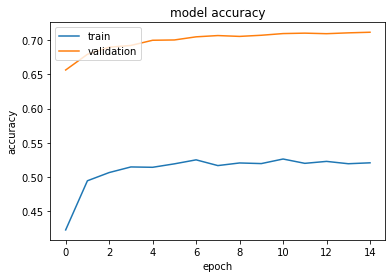

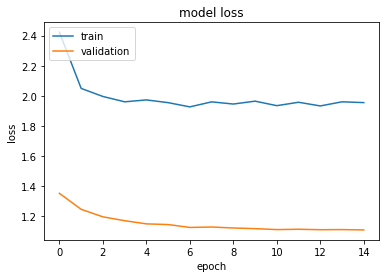

In [17]:
plot_hist(history)

In [18]:
model.save('model_pr_20.h5')

In [20]:
# load model
rec_model = keras.models.load_model('../input/pr-model/model_pr_20.h5')

In [21]:
# freeze all layers
for layer in rec_model.layers:
    layer.trainable = False

# unfeeze last 33 layers which is block 7 of the model
for layer in rec_model.layers[-33:]:
    if not isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = True
        
for layer in rec_model.layers[-40:]:
    print(layer.name, ':', layer.trainable)

block6f_se_expand : False
block6f_se_excite : False
block6f_project_conv : False
block6f_project_bn : False
block6f_drop : False
block6f_add : False
block7a_expand_conv : False
block7a_expand_bn : False
block7a_expand_activation : True
block7a_dwconv : True
block7a_bn : False
block7a_activation : True
block7a_se_squeeze : True
block7a_se_reshape : True
block7a_se_reduce : True
block7a_se_expand : True
block7a_se_excite : True
block7a_project_conv : True
block7a_project_bn : False
block7b_expand_conv : True
block7b_expand_bn : False
block7b_expand_activation : True
block7b_dwconv : True
block7b_bn : False
block7b_activation : True
block7b_se_squeeze : True
block7b_se_reshape : True
block7b_se_reduce : True
block7b_se_expand : True
block7b_se_excite : True
block7b_project_conv : True
block7b_project_bn : False
block7b_drop : True
block7b_add : True
top_conv : True
top_bn : False
top_activation : True
avg_pool : True
dropout : True
dense : True


In [23]:
# Learning rate warming up scheduler
LR_START = 0.00001
LR_MAX = 0.00005
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 8
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8 

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [23]:
# lower learning rate and continue training
optimizer = keras.optimizers.Adam(lr=1e-4)
rec_model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', 
                  metrics=["sparse_categorical_accuracy"])
history1 = rec_model.fit(train_set, epochs=20, 
                        validation_data=valid_set,
                        callbacks=[lr_callback])

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
2012/2012 [==============================] - 536s 262ms/step - loss: 1.8241 - sparse_categorical_accuracy: 0.5410 - val_loss: 1.0393 - val_sparse_categorical_accuracy: 0.7319
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 1.5000000000000002e-05.
2012/2012 [==============================] - 529s 262ms/step - loss: 1.7006 - sparse_categorical_accuracy: 0.5666 - val_loss: 1.0068 - val_sparse_categorical_accuracy: 0.7366
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 2e-05.
2012/2012 [==============================] - 523s 259ms/step - loss: 1.7096 - sparse_categorical_accuracy: 0.5653 - val_loss: 0.9738 - val_sparse_categorical_accuracy: 0.7453
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 2.5000000000000005e-05.
2012/2012 [==============================] - 528s 261ms/step - loss: 1.6440 - sparse_categorical_accuracy: 0.5816 - val_l

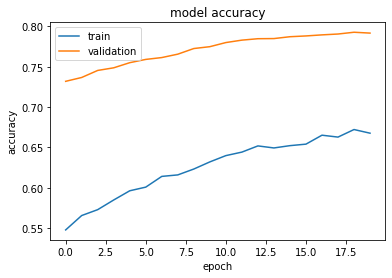

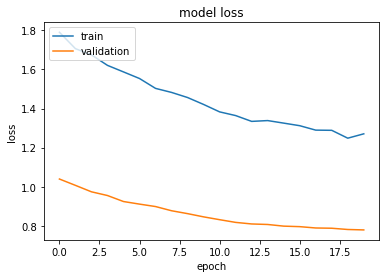

In [24]:
plot_hist(history1)

In [25]:
rec_model.evaluate(test_set, steps=TEST_STEPS)

355/355 [==============================] - 53s 147ms/step - loss: 0.5718 - sparse_categorical_accuracy: 0.83836s - loss: 0.


[0.5717853903770447, 0.8382922410964966]

In [26]:
rec2_model = keras.models.load_model('../input/pr-model/model_pr_20.h5')

In [27]:
# freeze all layers
for layer in rec2_model.layers:
    layer.trainable = False

# unfreeze last 122 layers (block 6)
for layer in rec2_model.layers[-122:]:
    if not isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = True
        
for layer in rec2_model.layers[-130:-100]:
    print(layer.name, ':', layer.trainable)

block5e_se_reduce : False
block5e_se_expand : False
block5e_se_excite : False
block5e_project_conv : False
block5e_project_bn : False
block5e_drop : False
block5e_add : False
block6a_expand_conv : False
block6a_expand_bn : False
block6a_expand_activation : True
block6a_dwconv_pad : True
block6a_dwconv : True
block6a_bn : False
block6a_activation : True
block6a_se_squeeze : True
block6a_se_reshape : True
block6a_se_reduce : True
block6a_se_expand : True
block6a_se_excite : True
block6a_project_conv : True
block6a_project_bn : False
block6b_expand_conv : True
block6b_expand_bn : False
block6b_expand_activation : True
block6b_dwconv : True
block6b_bn : False
block6b_activation : True
block6b_se_squeeze : True
block6b_se_reshape : True
block6b_se_reduce : True


In [28]:
rec2_model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', 
                   metrics=["sparse_categorical_accuracy"])
history2 = rec2_model.fit(train_set, epochs=20, validation_data=valid_set,
                        callbacks=[lr_callback])

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
2012/2012 [==============================] - 562s 274ms/step - loss: 1.7834 - sparse_categorical_accuracy: 0.5499 - val_loss: 0.9958 - val_sparse_categorical_accuracy: 0.7403
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 1.5000000000000002e-05.
2012/2012 [==============================] - 553s 273ms/step - loss: 1.6424 - sparse_categorical_accuracy: 0.5790 - val_loss: 0.9433 - val_sparse_categorical_accuracy: 0.7512
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 2e-05.
2012/2012 [==============================] - 555s 275ms/step - loss: 1.5363 - sparse_categorical_accuracy: 0.6057 - val_loss: 0.8992 - val_sparse_categorical_accuracy: 0.7627
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 2.5000000000000005e-05.
2012/2012 [==============================] - 551s 273ms/step - loss: 1.4558 - sparse_categorical_accuracy: 0.6261 - val_l

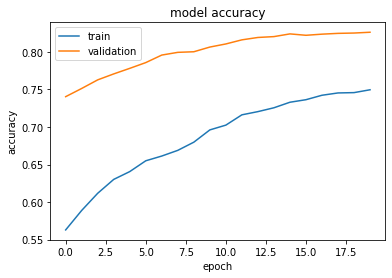

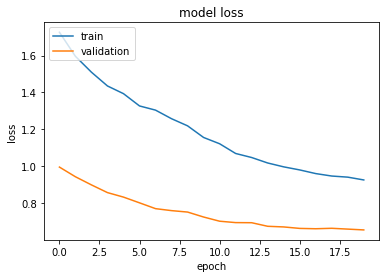

In [29]:
plot_hist(history2)

In [30]:
rec2_model.evaluate(test_set)

789/789 [==============================] - 118s 148ms/step - loss: 0.4580 - sparse_categorical_accuracy: 0.8685


[0.45800119638442993, 0.8684648275375366]

In [32]:
rec3_model = keras.models.load_model('../input/pr-model/model_pr_20.h5')

In [33]:
# freeze all layers
for layer in rec3_model.layers:
    layer.trainable = False

# unfreeze last 195 layers (block 5) 
for layer in rec3_model.layers[-195:]:
    if not isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = True
        
for layer in rec3_model.layers[-199:-185]:
    print(layer.name, ':', layer.trainable)

block4e_project_bn : False
block4e_drop : False
block4e_add : False
block5a_expand_conv : False
block5a_expand_bn : False
block5a_expand_activation : True
block5a_dwconv : True
block5a_bn : False
block5a_activation : True
block5a_se_squeeze : True
block5a_se_reshape : True
block5a_se_reduce : True
block5a_se_expand : True
block5a_se_excite : True


In [34]:
rec3_model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', 
                   metrics=["sparse_categorical_accuracy"])
history3 = rec3_model.fit(train_set, epochs=20, validation_data=valid_set,
                        callbacks=[lr_callback])

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
2012/2012 [==============================] - 609s 297ms/step - loss: 1.7115 - sparse_categorical_accuracy: 0.5676 - val_loss: 0.9614 - val_sparse_categorical_accuracy: 0.7459
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 1.5000000000000002e-05.
2012/2012 [==============================] - 601s 297ms/step - loss: 1.5407 - sparse_categorical_accuracy: 0.6055 - val_loss: 0.8891 - val_sparse_categorical_accuracy: 0.7643
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 2e-05.
2012/2012 [==============================] - 591s 292ms/step - loss: 1.4262 - sparse_categorical_accuracy: 0.6301 - val_loss: 0.8422 - val_sparse_categorical_accuracy: 0.7772
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 2.5000000000000005e-05.
2012/2012 [==============================] - 591s 293ms/step - loss: 1.3761 - sparse_categorical_accuracy: 0.6444 - val_l

In [35]:
rec3_model.evaluate(test_set)

789/789 [==============================] - 127s 160ms/step - loss: 0.4179 - sparse_categorical_accuracy: 0.8807


[0.4178617298603058, 0.8806638121604919]

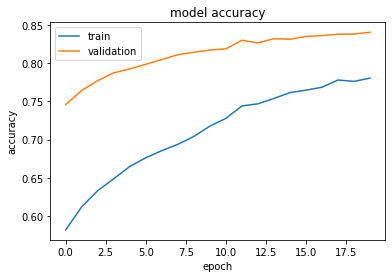

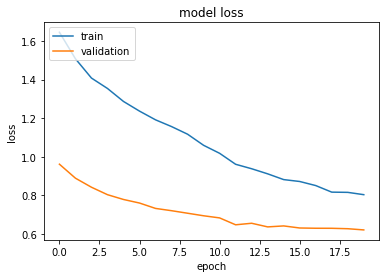

In [36]:
plot_hist(history3)